# **Сравнение методов глубоко обучения для классификации изображений**

В этом ноутбуке я првоеду сравнение нескольких моделей классификации изображений: [VGG16](https://keras.io/api/applications/vgg/#vgg16-function), [ResNet50](https://keras.io/api/applications/resnet/#resnet50-function), [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function), [NASNetMobile](https://keras.io/api/applications/nasnet/#nasnetmobile-function) по следующим показателям: размер, время работы, ошибка, и точность на тестовом множестве. Также будут проведены шумовые и патч атаки.
Для сравнения используются предобученные версии моделей, а для проверки - [ImageNet mini](https://www.kaggle.com/ifigotin/imagenetmini-1000/notebooks)

In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import gc

from pathlib import Path

Структура датасета

In [2]:
counter = 0

for dirname, _, filenames in os.walk('/kaggle/input'):
    counter += 1
    if counter == 6:
        break
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/imagenetmini-1000/imagenet-mini/val/n04536866/ILSVRC2012_val_00007249.JPEG
/kaggle/input/imagenetmini-1000/imagenet-mini/val/n04536866/ILSVRC2012_val_00016531.JPEG


Для глобальной проверки моделей используется тренировочное множество.

Для проверки на зашумленных и неполных данных достаточно ограничиться валидационным

In [3]:
TEST_PATH = Path('/kaggle/input/imagenetmini-1000/imagenet-mini/val/')
TEST_PATH_LARGE = Path('/kaggle/input/imagenetmini-1000/imagenet-mini/train/')
MODELS_NAMES = ['VGG16', 'ResNet50', 'MobileNetV2', 'NASNetMobile']

INPUT_SIZE = 224 # Все предобученные модели с фиксированным входом 224х224х3


label_name = [subdir for subdir in os.listdir(TEST_PATH) if os.path.isdir(os.path.join(TEST_PATH, subdir))]
print(f'Количество классов: {len(label_name)}')

img_name_large = [name for subdir in os.listdir(TEST_PATH_LARGE) for name in os.listdir(os.path.join(TEST_PATH_LARGE, subdir)) if os.path.isfile(os.path.join(TEST_PATH_LARGE, subdir, name))]
steps_large = len(img_name_large)
img_name_small = [name for subdir in os.listdir(TEST_PATH) for name in os.listdir(os.path.join(TEST_PATH, subdir)) if os.path.isfile(os.path.join(TEST_PATH, subdir, name))]
steps_small = len(img_name_small)
print(f'Количество изображений: {steps_large + steps_small}')

Количество классов: 1000
Количество изображений: 38668


Необходимо создать генератор изображений с двумя типами атак: добавление шума и вырез центральной области

In [4]:
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_input_mobilenet_v2
from tensorflow.keras.applications.nasnet import preprocess_input as preprocess_input_nasnetmobile


def add_noise(img, noise_level=0):
    VARIABILITY = noise_level
    deviation = VARIABILITY * random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

def center_crop(img, center_crop_size=(0, 0)):
    centerw, centerh = img.shape[0] // 2, img.shape[1] // 2
    halfw, halfh = center_crop_size[0] // 2, center_crop_size[1] // 2
    img[centerw - halfw:centerw + halfw, centerh - halfh:centerh + halfh, :] = 255
    return img


def noise_and_preprocess(preprocess_func, noise_level=0, noise_func=add_noise):
    return lambda x: preprocess_func(noise_func(x, noise_level))


def crop_and_preprocess(preprocess_func, center_crop_size=(0, 0), crop_func=center_crop):
    return lambda x: preprocess_func(crop_func(x, center_crop_size))


def preprocessed_generator(preprocess_input, path=TEST_PATH, input_size=INPUT_SIZE, noise_level=0, center_crop_size=(0, 0), noise=True, rescale=False, crop=False):
    if crop:
        datagen = ImageDataGenerator(
        rescale = 1./255 if rescale  else 1,
        preprocessing_function=crop_and_preprocess(preprocess_input, center_crop_size=center_crop_size) if noise else preprocess_input
    )
    else:
        datagen = ImageDataGenerator(
            rescale = 1./255 if rescale  else 1,
            preprocessing_function=noise_and_preprocess(preprocess_input, noise_level=noise_level) if noise else preprocess_input
        )
    
    generator = datagen.flow_from_directory(
        path,
        target_size=(INPUT_SIZE, INPUT_SIZE),
        batch_size=1,
        shuffle=False
    )
    return generator

# Визуалицаия данных

Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.


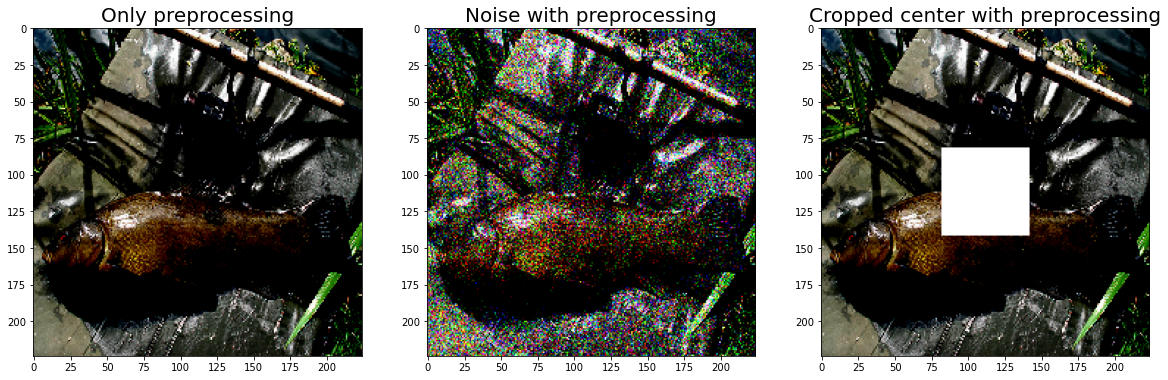

In [5]:
test_generator_mobilenet_v2_without = preprocessed_generator(preprocess_input_mobilenet_v2, noise_level=0)
test_generator_mobilenet_v2_noised = preprocessed_generator(preprocess_input_mobilenet_v2, noise_level=50)
test_generator_mobilenet_v2_cropped = preprocessed_generator(preprocess_input_mobilenet_v2, center_crop_size=(60, 60), crop=True)


fig, axes = plt.subplots(1, 3)
fontsize = 20

train_sample, y_train = next(test_generator_mobilenet_v2_without)
axes[0].imshow(train_sample[0])
axes[0].set_title('Only preprocessing', fontsize=fontsize)

train_sample, y_train = next(test_generator_mobilenet_v2_noised)
axes[1].imshow(train_sample[0])
axes[1].set_title('Noise with preprocessing', fontsize=fontsize)

train_sample, y_train = next(test_generator_mobilenet_v2_cropped)
axes[2].imshow(train_sample[0])
axes[2].set_title('Cropped center with preprocessing', fontsize=fontsize)

fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

# Глобальное тестирование

Импорт предобученных моделей

In [6]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.applications.nasnet import  NASNetMobile
from time import time

INPUT_SHAPE = (INPUT_SIZE, INPUT_SIZE, 3)

Функция для сбора ключевых параметров моделей:
* $size$ $-$ количество параметров модели 
* $time$ $-$ время обработки тестового множества
* $loss = H(p, q)=-\sum\limits_{x}-p(x)log(q(x))$ $-$ ошибка на тестовом множестве
* $acc(accuracy)=\frac{\sum true}{\sum true + \sum false}$ $-$ точность на тестовом множестве

In [7]:
def get_model_statistics(model, generator, steps=steps_large, optimizer=SGD, lr=5e-5, loss=categorical_crossentropy):
    statistics = dict.fromkeys(['size', 'time', 'loss', 'acc'])
    pretrained_model = model()
    pretrained_model.compile(optimizer=optimizer(learning_rate=lr), loss=loss, metrics = ['acc'])
    
    statistics['size'] = pretrained_model.count_params()
    
    start = time()
    test_scores = pretrained_model.evaluate(generator, steps=steps)
    statistics['time'] = time() - start
    
    statistics['loss'] = test_scores[0]
    statistics['acc'] = test_scores[1]
    
    return statistics

Сравнение размера, точности, ошибки и времени выполнения предсказаний на оригинальных данных

In [8]:
test_generator_vgg16 = preprocessed_generator(preprocess_input_vgg16, noise=False, path=TEST_PATH_LARGE)
test_generator_resnet50 = preprocessed_generator(preprocess_input_resnet50, noise=False, path=TEST_PATH_LARGE)
test_generator_mobilenet_v2 = preprocessed_generator(preprocess_input_mobilenet_v2, noise=False, path=TEST_PATH_LARGE)
test_generator_nasnetmobile = preprocessed_generator(preprocess_input_nasnetmobile, noise=False, path=TEST_PATH_LARGE)

Found 34745 images belonging to 1000 classes.
Found 34745 images belonging to 1000 classes.
Found 34745 images belonging to 1000 classes.
Found 34745 images belonging to 1000 classes.


In [9]:
with tf.device('/GPU:0'):
    stat_vgg16 = get_model_statistics(VGG16, test_generator_vgg16)
    stat_resnet50 = get_model_statistics(ResNet50, test_generator_resnet50)
    stat_mobilenet_v2 = get_model_statistics(MobileNetV2, test_generator_mobilenet_v2)
    stat_nasnetmobile = get_model_statistics(NASNetMobile, test_generator_nasnetmobile)

noise_statistics = {0: [stat_vgg16, stat_resnet50, stat_mobilenet_v2, stat_nasnetmobile]}

34745/34745 [==============================] - 868s 25ms/step - loss: 0.8239 - acc: 0.7997


In [10]:
sizes = [model['size'] for model in noise_statistics[0]]
times = [model['time'] for model in noise_statistics[0]]
losses = [model['loss'] for model in noise_statistics[0]]
accuracies = [model['acc'] for model in noise_statistics[0]]

Втзуализация сравнения

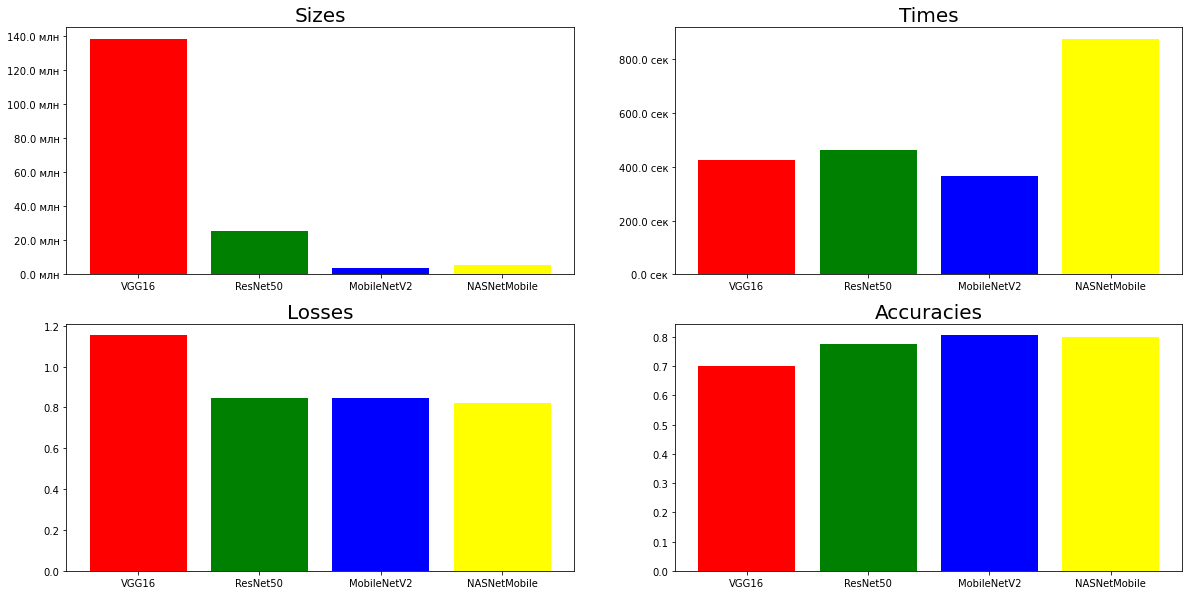

In [11]:
from matplotlib.ticker import FuncFormatter

N = np.arange(len(MODELS_NAMES))

def sizes_format(x, pos):
    return '%1.1f млн' % (x * 1e-6)


def times_format(x, pos):
    return '%1.1f сек' % (x)


fig = plt.figure(figsize=(20,10))


def plot_bar(stat, i, title, formatter=None, x=np.arange(len(MODELS_NAMES))):
    fontsize = 20
    ax = fig.add_subplot(2, 2,i + 1)
    if formatter:
        formatter = FuncFormatter(formatter)
        ax.yaxis.set_major_formatter(formatter)
    ax.set_title(title, fontsize=fontsize)
    plt.bar(x, stat, color=['r', 'g', 'b', 'yellow'])
    plt.xticks(x, MODELS_NAMES)
    

plot_bar(sizes, title='Sizes', formatter=sizes_format, i=0)
plot_bar(times, title='Times', formatter=times_format, i=1)
plot_bar(losses, title='Losses', i=2)
plot_bar(accuracies, title='Accuracies', i=3)
plt.show()

Выводы:
1. VGG16 значительно превосходит другие модели по размеру 
2. NASNetMobile имеет самый низкий показатель ошибки и сравнительно долгое время выполнения, однако, как показано ниже, это связанно с архитектурой
3. MobileNetV2 обходит все модели по точности и времени выполнения (даже учитыыая, что вычисления на GPU)

Сравнение времени работы моделей при использовании CPU

In [12]:
with tf.device('/CPU:0'):
    stat_vgg16 = get_model_statistics(VGG16, test_generator_vgg16, steps=200)
    stat_resnet50 = get_model_statistics(ResNet50, test_generator_resnet50, steps=200)
    stat_mobilenet_v2 = get_model_statistics(MobileNetV2, test_generator_mobilenet_v2, steps=200)
    stat_nasnetmobile = get_model_statistics(NASNetMobile, test_generator_nasnetmobile, steps=200)

200/200 [==============================] - 26s 128ms/step - loss: 0.5046 - acc: 0.8850


 Вывод: NASNetMobile хорошо подходит для вычислений на CPU, в отличие от абсолютно для этого непригодного VGG16, по прежнему самый быстрый - MobileNetV2

# Зависимость точностей моделей от уровня шума

Для этого можно использовать валидационное множество, которое меньше тренировочного почти в 10 раз

In [13]:
noise_statistics = {}

for noise_level in np.linspace(0, 100, 11):
    test_generator_vgg16 = preprocessed_generator(preprocess_input_vgg16, noise_level=noise_level)
    test_generator_resnet50 = preprocessed_generator(preprocess_input_resnet50, noise_level=noise_level)
    test_generator_mobilenet_v2 = preprocessed_generator(preprocess_input_mobilenet_v2, noise_level=noise_level)
    test_generator_nasnetmobile = preprocessed_generator(preprocess_input_nasnetmobile, noise_level=noise_level)
    
    stat_vgg16 = get_model_statistics(VGG16, test_generator_vgg16, steps=steps_small)
    stat_resnet50 = get_model_statistics(ResNet50, test_generator_resnet50, steps=steps_small)
    stat_mobilenet_v2 = get_model_statistics(MobileNetV2, test_generator_mobilenet_v2, steps=steps_small)
    stat_nasnetmobile = get_model_statistics(NASNetMobile, test_generator_nasnetmobile, steps=steps_small)
    noise_statistics[noise_level] = [stat_vgg16, stat_resnet50, stat_mobilenet_v2, stat_nasnetmobile]

Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
3923/3923 [==============================] - 114s 29ms/step - loss: 1.2536 - acc: 0.7099
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
3923/3923 [==============================] - 113s 29ms/step - loss: 1.3096 - acc: 0.6974
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
3923/3923 [==============================] - 115s 29ms/step - loss: 1.4225 - acc: 0.6763
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
3923/3923 [==

In [14]:
def plot_noises_and_metric(statistics, models_names, metric):
    
    for (i, name) in enumerate(models_names):
        noises = [key for key in statistics.keys()]
        metrics = [statistics[nl][i][metric] for nl in noises]
        plt.plot(noises, metrics, label=name)
    plt.title(f'{metric} with noise')
    plt.legend()
    plt.xlabel("noises")
    plt.ylabel(f"{metric}")

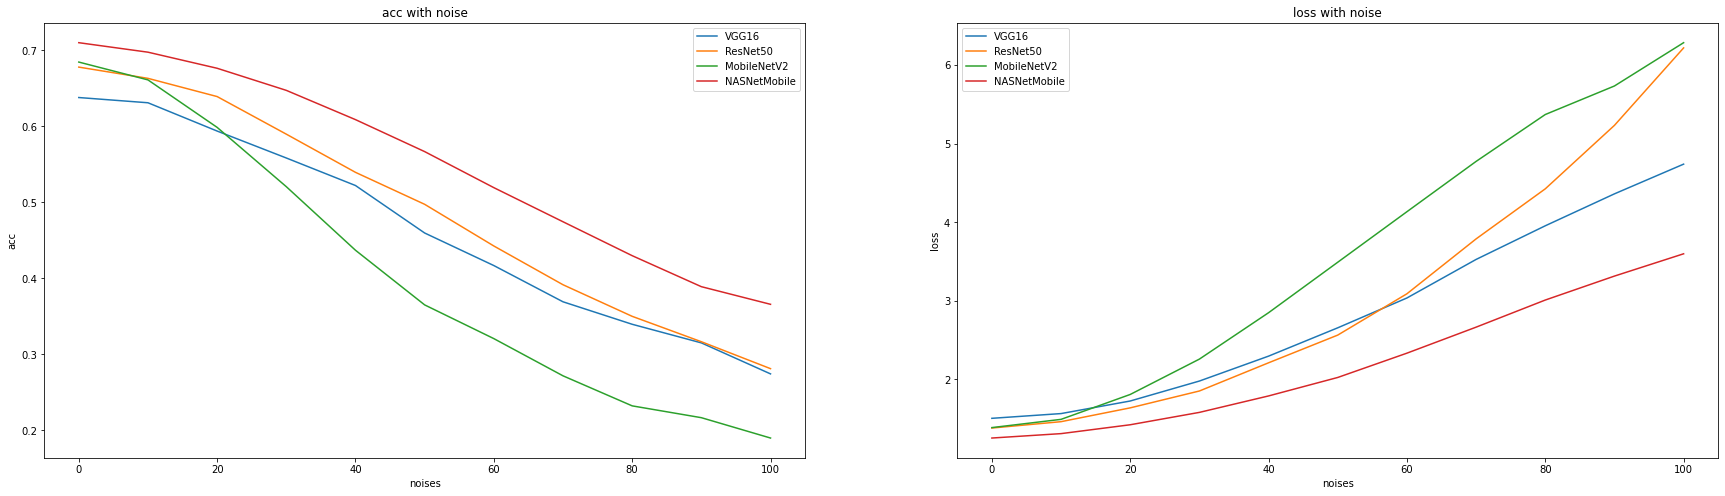

In [15]:
plt.figure(figsize=(30,8))
plt.subplot(1, 2, 1)
plot_noises_and_metric(noise_statistics, MODELS_NAMES, metric='acc')
plt.subplot(1, 2, 2)
plot_noises_and_metric(noise_statistics, MODELS_NAMES, metric='loss')
plt.show()

Выводы:
1. MobileNetV2 очень чувствителен к добавлению шума
2. NASNetMobile показывает отличные результаты
3. VGG16 и ResNet50 стабильны

# Зависимость очностей моделей от размера вырезанного в центре квадрата

In [16]:
crop_statistics = {}

with tf.device('/GPU:0'):
    for crop_size in np.linspace(20, 160, 6):
        crop_size = int(crop_size)
        
        test_generator_vgg16 = preprocessed_generator(preprocess_input_vgg16, center_crop_size=(crop_size, crop_size), crop=True)
        test_generator_resnet50 = preprocessed_generator(preprocess_input_resnet50, center_crop_size=(crop_size, crop_size), crop=True)
        test_generator_mobilenet_v2 = preprocessed_generator(preprocess_input_mobilenet_v2, center_crop_size=(crop_size, crop_size), crop=True)
        test_generator_nasnetmobile = preprocessed_generator(preprocess_input_nasnetmobile, center_crop_size=(crop_size, crop_size), crop=True)

        stat_vgg16 = get_model_statistics(VGG16, test_generator_vgg16, steps=steps_small)
        stat_resnet50 = get_model_statistics(ResNet50, test_generator_resnet50, steps=steps_small)
        stat_mobilenet_v2 = get_model_statistics(MobileNetV2, test_generator_mobilenet_v2, steps=steps_small)
        stat_nasnetmobile = get_model_statistics(NASNetMobile, test_generator_nasnetmobile, steps=steps_small)
        crop_statistics[crop_size] = [stat_vgg16, stat_resnet50, stat_mobilenet_v2, stat_nasnetmobile]

Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
3923/3923 [==============================] - 89s 23ms/step - loss: 1.4186 - acc: 0.6796
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
3923/3923 [==============================] - 90s 23ms/step - loss: 1.8992 - acc: 0.5942
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
3923/3923 [==============================] - 82s 21ms/step - loss: 2.7032 - acc: 0.4522
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
Found 3923 images belonging to 1000 classes.
3923/3923 [=====

In [17]:
def plot_crop_and_metric(statistics, models_names, metric):
    for (i, name) in enumerate(models_names):
        noises = [key for key in statistics.keys()]
        metrics = [statistics[nl][i][metric] for nl in noises]
        plt.plot(noises, metrics, label=name)
    plt.title(f'{metric} with cropped center')
    plt.legend()
    plt.xlabel("crop sizes")
    plt.ylabel(f"{metric}")

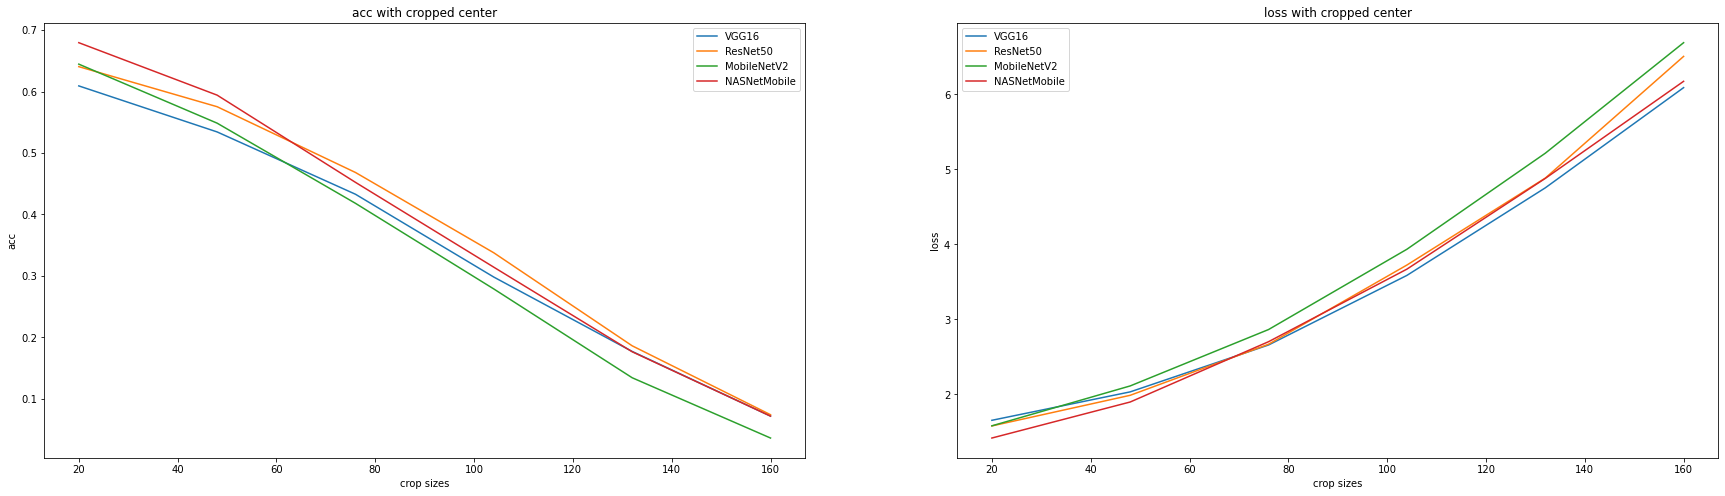

In [18]:
plt.figure(figsize=(30,8))
plt.subplot(1, 2, 1)
plot_crop_and_metric(crop_statistics, MODELS_NAMES, metric='acc')
plt.subplot(1, 2, 2)
plot_crop_and_metric(crop_statistics, MODELS_NAMES, metric='loss')
plt.show()

MobileNetV2 показывает худшие результаты, имея при этом довольно высокую стартовую точность

# Распределение точностей моделей на каждом классе

In [19]:
def get_model(model, optimizer=SGD, lr=5e-5, loss=categorical_crossentropy):
    pretrained_model = model()
    pretrained_model.compile(optimizer=optimizer(learning_rate=lr), loss=loss, metrics = ['acc'])
    return pretrained_model

In [20]:
from sklearn.metrics import classification_report

test_generator_vgg16 = preprocessed_generator(preprocess_input_vgg16, path=TEST_PATH_LARGE, noise=False)
test_generator_resnet50 = preprocessed_generator(preprocess_input_resnet50, path=TEST_PATH_LARGE, noise=False)
test_generator_mobilenet_v2 = preprocessed_generator(preprocess_input_mobilenet_v2, path=TEST_PATH_LARGE, noise=False)
test_generator_nasnetmobile = preprocessed_generator(preprocess_input_nasnetmobile, path=TEST_PATH_LARGE, noise=False)

generators = [test_generator_vgg16, test_generator_resnet50, test_generator_mobilenet_v2, test_generator_nasnetmobile]
models = [VGG16, ResNet50, MobileNetV2, NASNetMobile]

precisions = []
for model, generator in zip(models, generators):
    test_labels=generator.classes

    predictions=get_model(model).predict_generator(generator, verbose=1)

    y_pred = np.argmax(predictions, axis=-1)

    report = classification_report(test_labels, y_pred, output_dict=True)
    precision_report = [values['precision'] for values in list(report.values())[:-3]][::-1]
    precisions.append(precision_report)

Found 34745 images belonging to 1000 classes.
Found 34745 images belonging to 1000 classes.
Found 34745 images belonging to 1000 classes.
Found 34745 images belonging to 1000 classes.
34745/34745 [==============================] - 695s 20ms/step


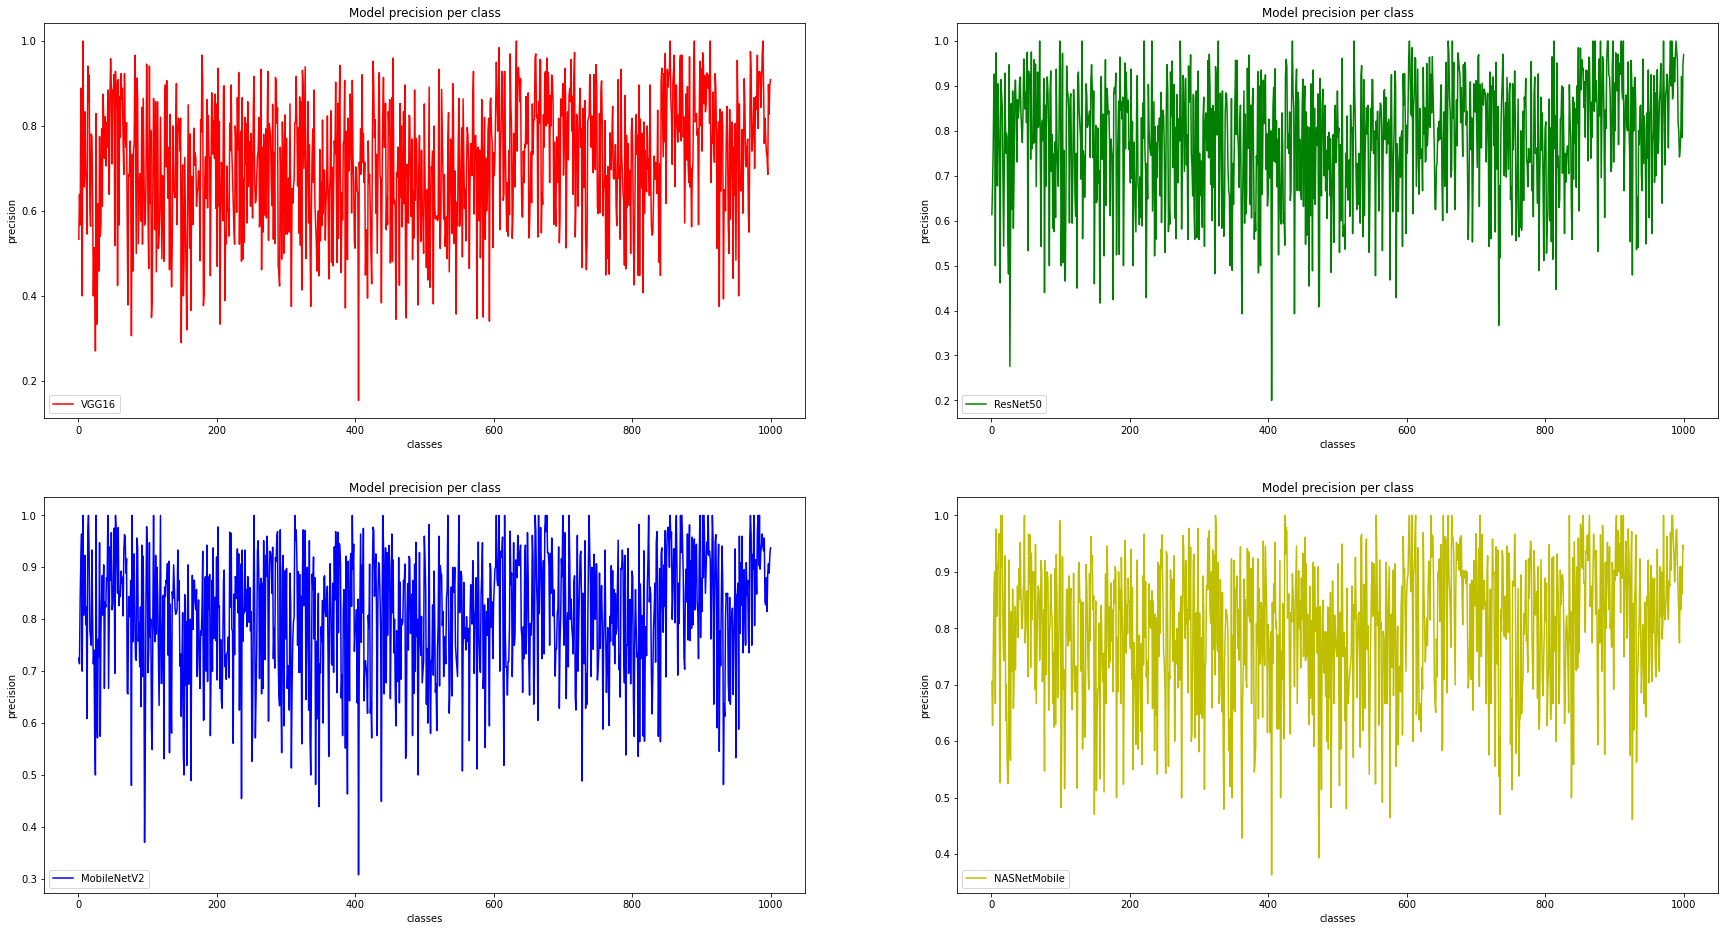

In [21]:
plt.figure(figsize=(30,16))

colors = ['r', 'g', 'b', 'y']

for i, (precision, name) in enumerate(zip(precisions, MODELS_NAMES)):
    plt.subplot(2, 2, i + 1)
    plt.plot(list(range(1, 1001)), precision, label=name, color=colors[i])
    plt.title('Model precision per class')
    plt.legend()
    plt.xlabel('classes')
    plt.ylabel('precision')
    
plt.show()

Если присмотреться, можно заметить схожие очертания (даже присутствуют одинаковые выбросы).

Среднее абсолютной разности каждой пары распределений

In [22]:
import itertools

for dist1, dist2 in list(itertools.combinations(precisions, 2)):
    print(np.mean(np.abs(np.array(dist1) - np.array(dist2))))

0.0905690797655298
0.1107288413392988
0.10418475459401554
0.06818586738738804
0.06818431267007204
0.06635605896452586


Точности моделей по каждому классу слабо отличаются друг от друга. В дополнение можно посмотреть на отсортированные по невозрастанию распределения

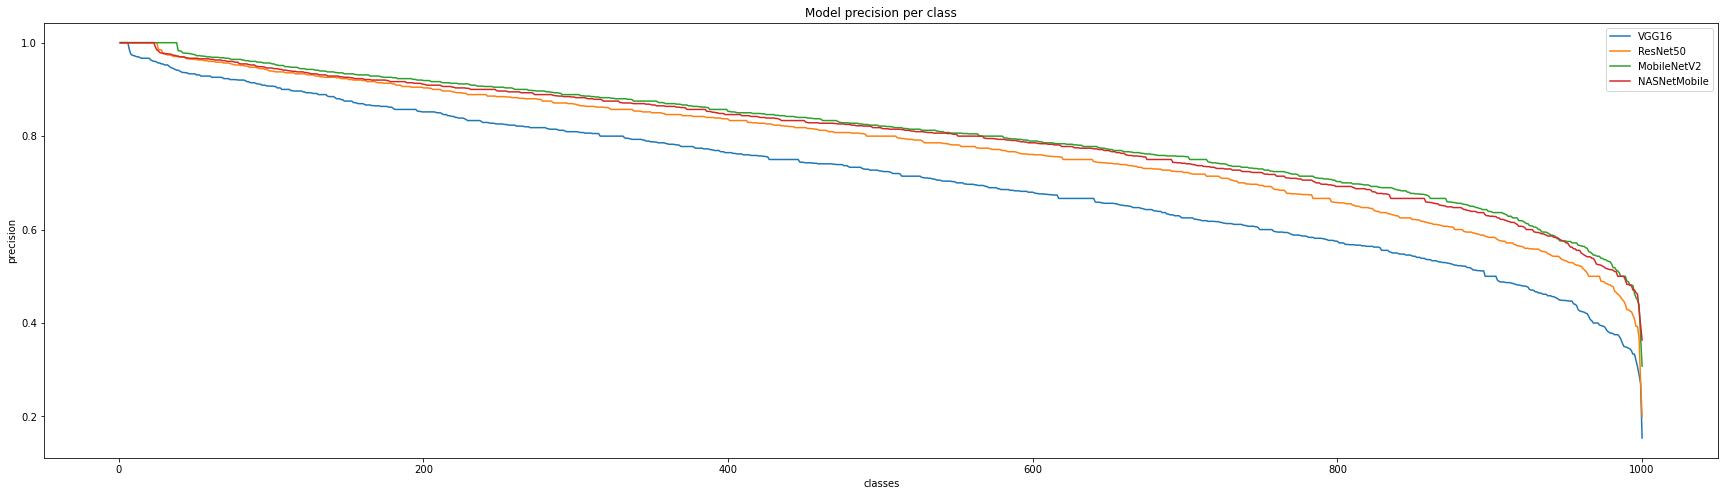

In [23]:
plt.figure(figsize=(30,8))

for precision, name in zip((precisions), MODELS_NAMES):
    plt.plot(list(range(1, 1001)), np.sort(precision)[::-1], label=name)
plt.title('Model precision per class')
plt.legend()
plt.xlabel('classes')
plt.ylabel('precision')
plt.show()

# Выбор модели

Конечно, в первую очередь все зависит от решаемой задачи и используемых ресурсов. Если данные зашумлены или неполны, однозначно не стоит использовать MobileNetV2.

VGG16 неплохо держится, однако 500 Mb $-$ это слишком большой размер, а при самой низкой точности, к сожалению, ни для какого случая не подходит на фоне того же ResNet50.

ResNet50 не сильно уступает MobileNetV2, а по точности на зашумленных или неполных данных сильно превосходит.

Ну и, наконец, NASNetMobile имеет сравнимую с MobileNetV2 точность и идеально подходит для работы с зашумленными или неполными данными (но на CPU MobileNetV2 превосходит по скорости в несколько раз).

Итог: я остановлюсь на NASNetMobile, как на наиболее универсальной.